# Error Plot JCPexample5

## Cavity Flow

## Import stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys

sys.path.append('../')

import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat
import pickle
import importlib
import DRLPDE.neuralnets as neuralnets

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

## Error Plot

In [2]:
loadmodel = 'JCP5'

filename = 'Error_Plot_' + loadmodel
imagesfolder = "images/"

with open('../experiments/' + loadmodel + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

with open('../experiments/'  + loadmodel + '_losses.pickle', 'rb') as f:
    losses = pickle.load(f)

problem = importlib.import_module(".JCPexample5", package='examples')

input_dim = [problem.x_dim, problem.t_dim, problem.hyper_dim]
output_dim = problem.output_dim

if parameters['neuralnetwork'] == 'FeedForward':
    MyNeuralNetwork = neuralnets.FeedForwardNN
elif parameters['neuralnetwork'] == 'Incompressible':
    MyNeuralNetwork = neuralnets.IncompressibleNN
elif parameters['neuralnetwork'] == 'ResNet':
        MyNeuralNetwork = neuralnets.ResNetNN
elif parameters['neuralnetwork'] == 'ResNetIncompressible':
    MyNeuralNetwork = neuralnets.ResNetIncompressible
    
nn_size = parameters['nn_size']

model = MyNeuralNetwork(input_dim, output_dim, **nn_size)
model.load_state_dict(torch.load("../savedmodels/" + loadmodel + ".pt"))

<All keys matched successfully>

### Setup Variables and Calculate Error

In [3]:
### Domain Parameters
dim_space = 2
dim_full = dim_space

L = 1
v0 = 1

### Error Grid
numplotpts1d = 128
numplotpts = numplotpts1d**2

x1g, x2g = torch.meshgrid([torch.linspace(-L, L, numplotpts1d), 
                           torch.linspace(-L, L, numplotpts1d)])
xg = torch.stack((x1g.reshape(-1), x2g.reshape(-1)), dim=1).requires_grad_(True)
integral_factor = ( 2/(numplotpts1d-1))**dim_space

### Load Finite Difference Solution
contents = loadmat('../tools/Cavity_Flow_2D_Data_128x128.mat')
u1_true = np.transpose(contents['u'])
u2_true = np.transpose(contents['v'])
u_true = np.concatenate( (u1_true[:,:,None], u2_true[:,:,None]), axis=dim_space)


### Evaluate the model

Trained_Vel = model(xg).reshape(numplotpts1d, numplotpts1d, 2).detach().numpy()

Trained_Vel_U = Trained_Vel[:,:,0]
Trained_Vel_V = Trained_Vel[:,:,1]

### Errors

L2_error = np.sqrt( np.sum( np.square(Trained_Vel_U - u1_true)*integral_factor) \
                   + np.sum( np.square(Trained_Vel_V - u2_true)*integral_factor))
Linf_error = np.amax( [np.amax( np.abs( Trained_Vel_U - u1_true)), 
                        np.amax( np.abs( Trained_Vel_V - u2_true))] )

L2_norm_true = np.sqrt( np.sum( np.square(u1_true)*integral_factor) \
                         + np.sum( np.square(u2_true)*integral_factor))

Linf_norm_true = np.amax( [np.amax(np.abs(u1_true)), np.amax(np.abs(u2_true))] )

print('L2 error is {:.5f}'.format(L2_error))
print('Linf error is {:.5f}'.format(Linf_error))

print('Relative L2 error is {:.5f}'.format(L2_error/L2_norm_true))
print('Relative Linf error is {:.5f}'.format(Linf_error/Linf_norm_true))


L2 error is 0.22650
Linf error is 0.65942
Relative L2 error is 0.44297
Relative Linf error is 0.65942


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Plot

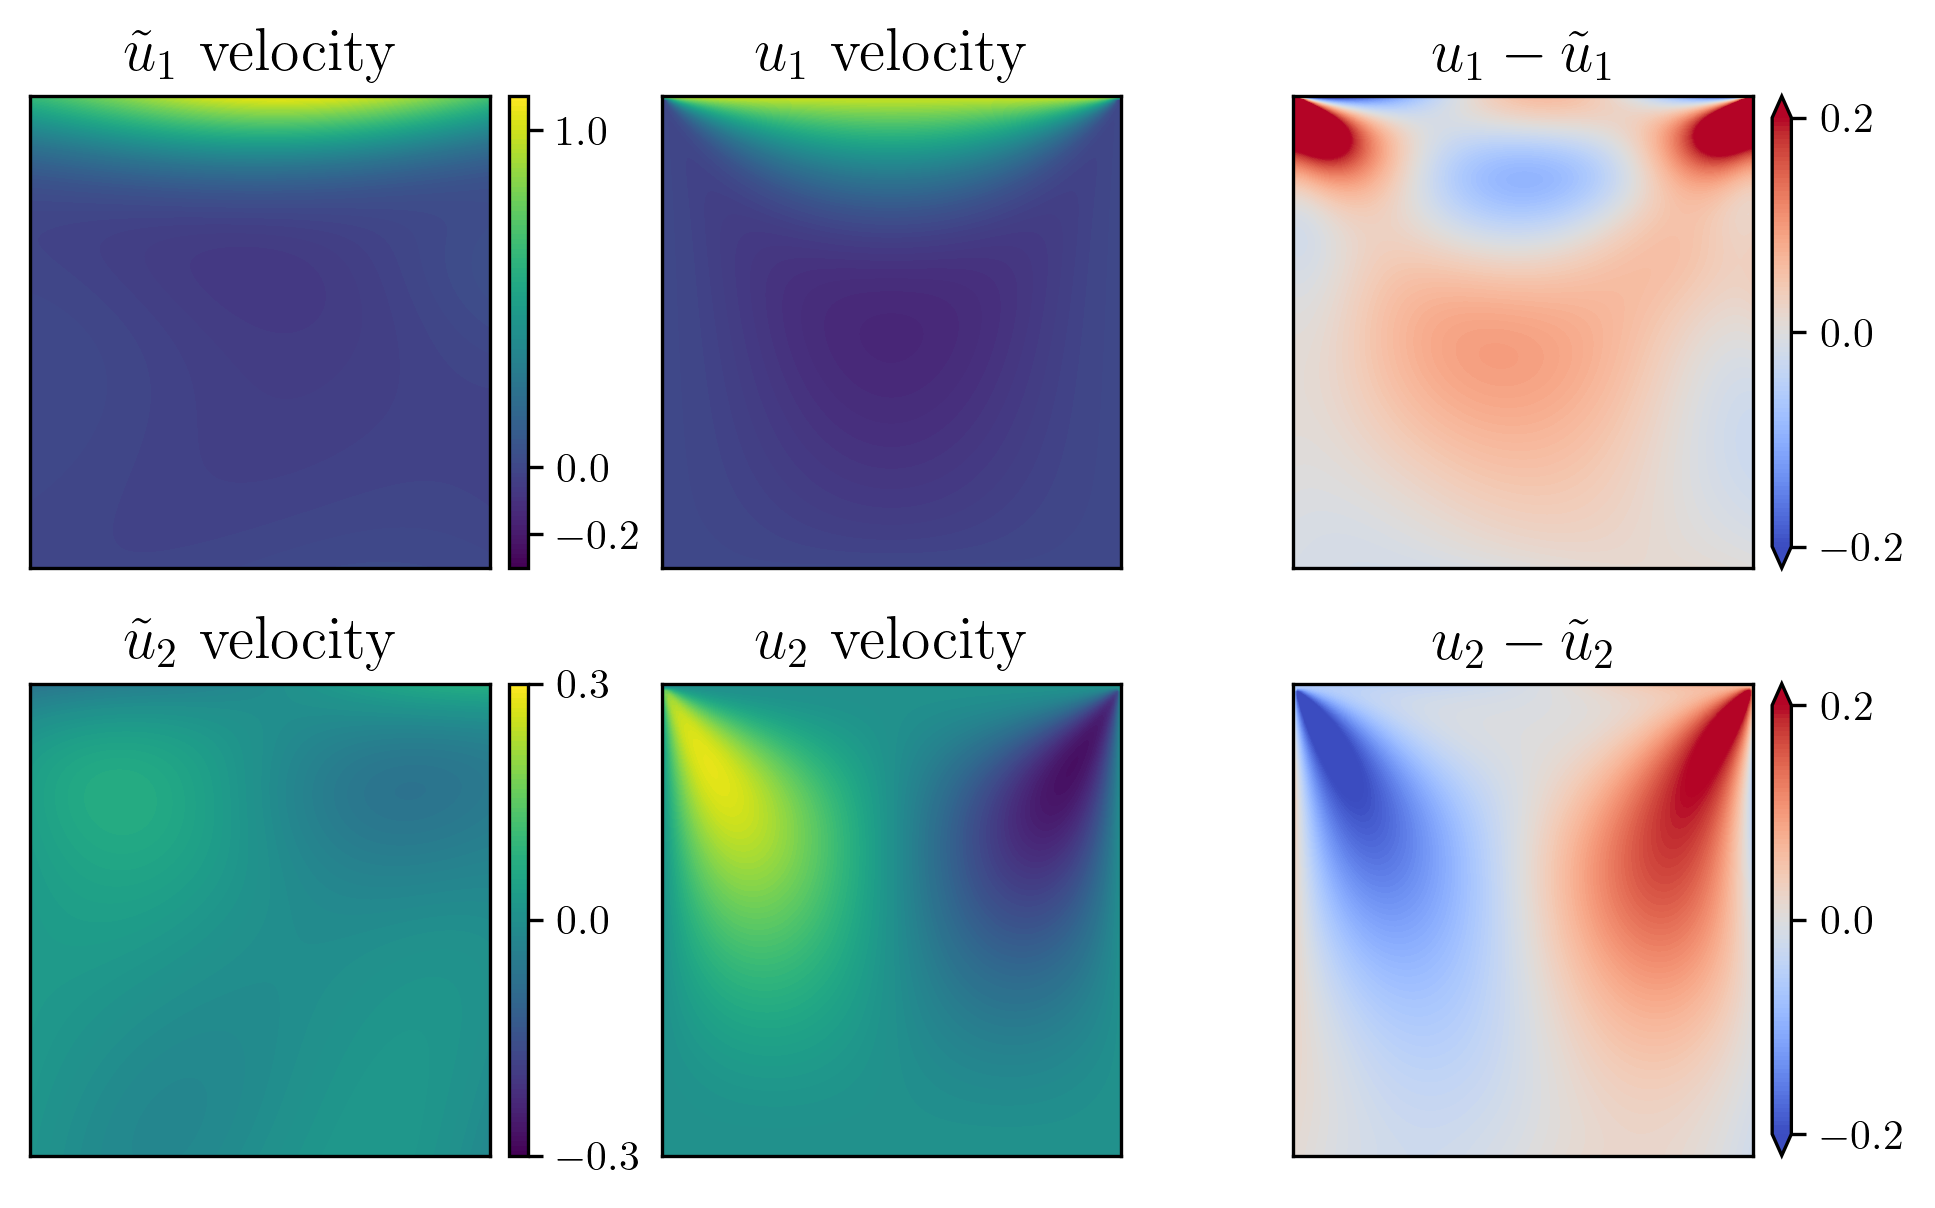

In [4]:
### Plotting

levels_cavity_flow_1 = np.linspace(-0.3, 1.1, 100)
ticks_cavity_flow_1  = [-0.2, 0.0, 1.0] #np.linspace(-0.2, 1.0, 2)

levels_cavity_flow_2 = np.linspace(-0.3, 0.3, 100)
ticks_cavity_flow_2  = np.linspace(-0.3, 0.3, 3)

levels_error = np.linspace(-0.2, 0.2, 100)
ticks_error = np.linspace(-0.2, 0.2, 3)

plt.close('all')
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=[6.4,4])
fig.tight_layout(pad=0.5)

## Plot 0

contour0 = ax[0,0].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            Trained_Vel_U, levels = levels_cavity_flow_1, 
                            cmap=plt.cm.viridis)
ax[0,0].set_title(r'$\tilde{u}_1$ velocity')

ax[0,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar0_param = fig.add_axes(
    [ax[0,0].get_position().x1 + 0.01,
     ax[0,0].get_position().y0,
     0.01,
     ax[0,0].get_position().height])
colorbar0 = plt.colorbar(contour0, ticks=ticks_cavity_flow_1, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)

## Plot 1

contour1 = ax[0,1].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            u1_true, levels = levels_cavity_flow_1, 
                            cmap=plt.cm.viridis)
ax[0,1].set_title(r'$u_1$ velocity')

ax[0,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

## Plot 2

contour2 = ax[0,2].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            Trained_Vel_U - u1_true, levels = levels_error,
                            cmap=plt.cm.coolwarm, extend='both')
ax[0,2].set_title(r'$u_1 - \tilde{u}_1$')

ax[0,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar2_param = fig.add_axes(
    [ax[0,2].get_position().x1 + 0.01,
     ax[0,2].get_position().y0,
     0.01,
     ax[0,2].get_position().height])
colorbar2 = plt.colorbar(contour2, ticks=ticks_error, cax = colorbar2_param)
colorbar2.ax.tick_params(labelsize=10)

## Plot 3

contour3 = ax[1,0].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            Trained_Vel_V, levels = levels_cavity_flow_2, 
                            cmap=plt.cm.viridis)
ax[1,0].set_title(r'$\tilde{u}_2$ velocity')

ax[1,0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar3_param = fig.add_axes(
    [ax[1,0].get_position().x1 + 0.01,
     ax[1,0].get_position().y0,
     0.01,
     ax[1,0].get_position().height])
colorbar3 = plt.colorbar(contour3, ticks=ticks_cavity_flow_2, cax = colorbar3_param)
colorbar3.ax.tick_params(labelsize=10)

## Plot 4

contour4 = ax[1,1].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            u2_true, levels = levels_cavity_flow_2, 
                            cmap=plt.cm.viridis)
ax[1,1].set_title(r'$u_2$ velocity')

ax[1,1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)


contour5 = ax[1,2].contourf(x1g.detach().cpu().numpy(), 
                            x2g.detach().cpu().numpy(), 
                            Trained_Vel_V - u2_true, levels = levels_error,
                            cmap=plt.cm.coolwarm, extend='both')
ax[1,2].set_title(r'$u_2 - \tilde{u}_2$')

ax[1,2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar5_param = fig.add_axes(
    [ax[1,2].get_position().x1 + 0.01,
     ax[1,2].get_position().y0,
     0.01,
     ax[1,2].get_position().height])
colorbar5 = plt.colorbar(contour5, ticks=ticks_error, cax = colorbar5_param)
colorbar5.ax.tick_params(labelsize=10)

In [5]:
steps = range(int(parameters['trainingsteps']))
L2loss = np.sqrt(losses[:,:,0])
Linfloss = np.sqrt(losses[:,:,1])

print('Final Interior L2 loss = {:.4f}'.format(L2loss[-1,0]))
print('Final Boundary L2 loss = {:.4f}'.format(L2loss[-1,1]))
print('Final Linf loss = {:.4f}'.format(Linfloss[-1,0]))

Final Interior L2 loss = 1.4202
Final Boundary L2 loss = 0.1771
Final Linf loss = 23.5846


Text(0.5, 59.88843513257575, 'number of steps')

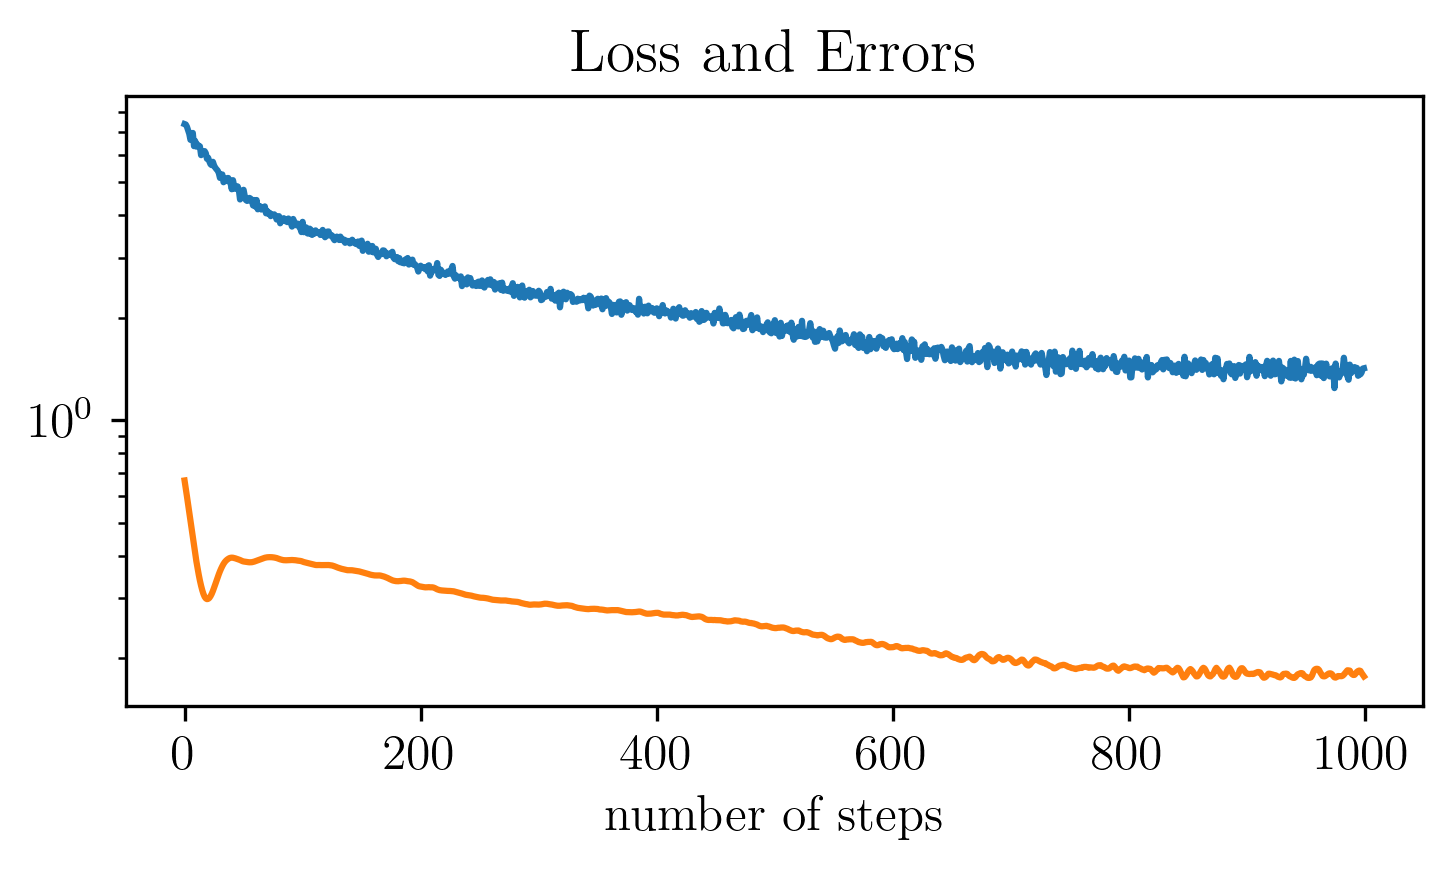

In [6]:
steps = range(int(parameters['trainingsteps']))
L2loss = losses[:,:,0]
Linfloss = np.sqrt(losses[:,:,1])
#L2error = np.sqrt(errors[:,:,0])
#Linferror = np.sqrt(np.amax(errors[:,:,1], axis=1))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 4])

plt.tight_layout(pad=5.0)

ax.set_title('Loss and Errors')

ax.semilogy(steps, np.sqrt(L2loss[:,0]))
ax.semilogy(steps, np.sqrt(L2loss[:,1]))
#ax.semilogy(steps, np.sqrt(Linfloss[:,0]))
#ax.semilogy(steps, L2error[:,0])
#ax.semilogy(steps, Linferror)
#ax.legend(['Interior L2 loss', 'Interior Linf loss', 'Interior L2 error', 'Interior Linf error'])
ax.set_xlabel('number of steps')

#ax[1].set_title('Comparing L2 loss and L2 error')
#ax[1].semilogy(steps, np.abs( 5.1148*L2loss - L2error) )